## Audio Classification using CNN

COE49412

Imran A. Zualkernan


Primary example #1 taken from: 
https://www.youtube.com/watch?v=Z7YM-HAz-IY&list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P&index=2&t=0s

In [249]:
# Plotting functions
# please install 
# pip install python_speech_features

import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank


def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [250]:
# Basic Libraries
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [300]:
# Reading in data 
df = pd.read_csv('audio/instruments.csv')
print(df.head)
# use file name as index
df = df.set_index("fname")
print(df.head)

<bound method NDFrame.head of             fname      label
0    5388d14d.wav  Saxophone
1    c685f05f.wav  Saxophone
2    36d20ab5.wav  Saxophone
3    d6665734.wav  Saxophone
4    7352e28f.wav  Saxophone
..            ...        ...
295  3c713bcf.wav   Clarinet
296  2fc00271.wav   Clarinet
297  b0c06255.wav   Clarinet
298  71c6451f.wav   Clarinet
299  5de123c3.wav   Clarinet

[300 rows x 2 columns]>
<bound method NDFrame.head of                   label
fname                  
5388d14d.wav  Saxophone
c685f05f.wav  Saxophone
36d20ab5.wav  Saxophone
d6665734.wav  Saxophone
7352e28f.wav  Saxophone
...                 ...
3c713bcf.wav   Clarinet
2fc00271.wav   Clarinet
b0c06255.wav   Clarinet
71c6451f.wav   Clarinet
5de123c3.wav   Clarinet

[300 rows x 1 columns]>


In [301]:
# read the length of the files 
for f in df.index:
    rate,signal = wavfile.read('audio/wavfiles/'+f)
    df.at[f,'length'] = signal.shape[0]/rate

# This give us the length of the signal in seconds. 
print(df.head)
print(df.index)

<bound method NDFrame.head of                   label  length
fname                          
5388d14d.wav  Saxophone    4.14
c685f05f.wav  Saxophone    1.54
36d20ab5.wav  Saxophone    4.90
d6665734.wav  Saxophone   10.50
7352e28f.wav  Saxophone    6.24
...                 ...     ...
3c713bcf.wav   Clarinet    6.14
2fc00271.wav   Clarinet    4.20
b0c06255.wav   Clarinet    4.08
71c6451f.wav   Clarinet    3.56
5de123c3.wav   Clarinet    3.34

[300 rows x 2 columns]>
Index(['5388d14d.wav', 'c685f05f.wav', '36d20ab5.wav', 'd6665734.wav',
       '7352e28f.wav', '8fa096bf.wav', '2f9c5f62.wav', '9cd05a2b.wav',
       'ab465bf9.wav', 'c40632d7.wav',
       ...
       'e43f7db2.wav', '3c66098d.wav', 'ad42e493.wav', '740e5bb7.wav',
       '800b401e.wav', '3c713bcf.wav', '2fc00271.wav', 'b0c06255.wav',
       '71c6451f.wav', '5de123c3.wav'],
      dtype='object', name='fname', length=300)


In [304]:
# grab the verious different classes
classes = list(np.unique(df.label))
print(classes)

# group by each class can calculate the mean
# length per group.

class_dist = df.groupby(['label'])
print(class_dist['length'].mean())

# Different labels have different sizes (in seconds)
df = df.reset_index()

['Acoustic_guitar', 'Bass_drum', 'Cello', 'Clarinet', 'Double_bass', 'Flute', 'Hi-hat', 'Saxophone', 'Snare_drum', 'Violin_or_fiddle']
label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi-hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length, dtype: float64


In [305]:
print(df.head)
wav_files = df[df.label=='Saxophone']  # all the 30 or so files
wav_file = wav_files.iloc[0,0]
print(wave_file)
for c in classes:
    print(c)

<bound method NDFrame.head of             fname      label  length
0    5388d14d.wav  Saxophone    4.14
1    c685f05f.wav  Saxophone    1.54
2    36d20ab5.wav  Saxophone    4.90
3    d6665734.wav  Saxophone   10.50
4    7352e28f.wav  Saxophone    6.24
..            ...        ...     ...
295  3c713bcf.wav   Clarinet    6.14
296  2fc00271.wav   Clarinet    4.20
297  b0c06255.wav   Clarinet    4.08
298  71c6451f.wav   Clarinet    3.56
299  5de123c3.wav   Clarinet    3.34

[300 rows x 3 columns]>
9c0838c1.wav
Acoustic_guitar
Bass_drum
Cello
Clarinet
Double_bass
Flute
Hi-hat
Saxophone
Snare_drum
Violin_or_fiddle


In [306]:
# Plotting the files
# this will give us one file at index 0,0 out of the 30 or so 
# for each class (labels)
import librosa

def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return Y, freq

signals = {}
fft = {}
fbank = {}
mfccs = {}

# Plotting the files
# this will give us one file at index 0,0 out of the 30 or so 
# for each class (labels)


import librosa

def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return Y, freq

signals = {}
fft = {}
fbank = {}
mfccs = {}


for c in classes:
    print(c)
    wav_files = df[df.label==c]  # all the 30 or so files
    wav_file = wav_files.iloc[0,0]
    try:
        signal, rate = librosa.load('audio/wavfiles/'+wav_file, sr=44100)
        signals[c] = signal
        fft[c] = calc_fft(signal, rate)
    
    # nfft = (44100samples/second) / (40 intervals/sec) = 1103
    # 40 intervals/sec = 25 milliseconds (resolution)
    # nfft = 1103 samples/interval (size of the window)
    # using 26 mel-spec filters 
    # getting data for one second i.e., signal[:44100] or 44100 samples
    
        bank = logfbank(signal[:rate],rate, nfilt=26,nfft=1103).T
        fbank[c] = bank
    
    ## note that nfilt was 26 so we throw away half giving 
    ## us the numcep of 13. So our features (y axis) will be 13
    ## since 1 second = 
    
        mfc= mfcc(signal[:rate],rate, numcep = 13, nfilt=26, nfft=1103).T
        mfccs[c] = mfc
    except: 
         print("Error: class=", c, " FileName=", wav_file)

Acoustic_guitar
Bass_drum
Cello
Clarinet
Double_bass
Flute
Hi-hat
Saxophone
Snare_drum
Violin_or_fiddle


In [307]:
df.head
signals

{'Acoustic_guitar': array([-1.7700195e-03, -2.5634766e-03, -4.2419434e-03, ...,
         0.0000000e+00, -6.1035156e-05,  0.0000000e+00], dtype=float32),
 'Bass_drum': array([ 1.1291504e-03,  1.1291504e-03,  1.1901855e-03, ...,
        -3.0517578e-05, -3.0517578e-05, -3.0517578e-05], dtype=float32),
 'Cello': array([-6.7138672e-04, -6.4086914e-04, -6.7138672e-04, ...,
        -3.0517578e-05, -3.0517578e-05, -3.0517578e-05], dtype=float32),
 'Clarinet': array([ 3.3569336e-04,  3.6621094e-04,  3.3569336e-04, ...,
        -6.1035156e-05,  0.0000000e+00,  0.0000000e+00], dtype=float32),
 'Double_bass': array([ 3.6010742e-03,  3.8452148e-03,  4.1809082e-03, ...,
         3.0517578e-05, -6.1035156e-05,  0.0000000e+00], dtype=float32),
 'Flute': array([0.00018311, 0.00024414, 0.00021362, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 'Hi-hat': array([-4.8828125e-04,  9.1552734e-05, -1.0070801e-03, ...,
        -6.1035156e-05, -3.0517578e-05, -3.0517578e-05], dtype=float32),

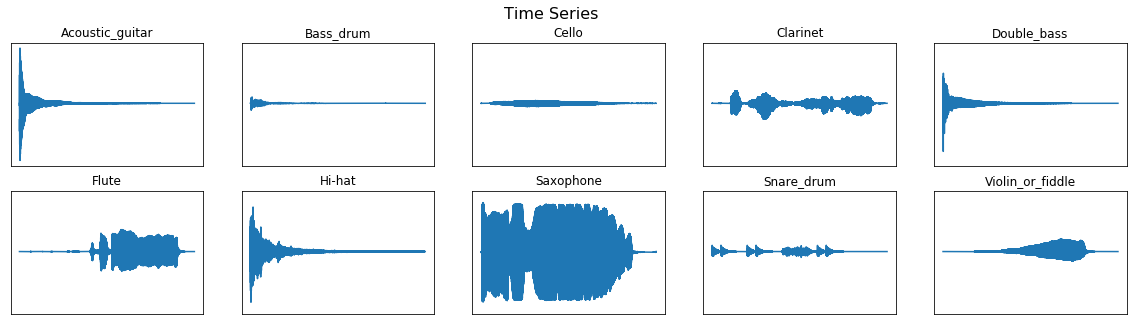

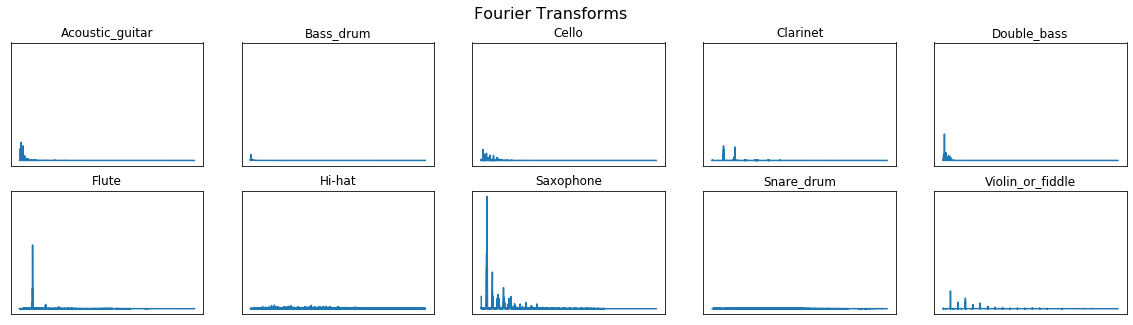

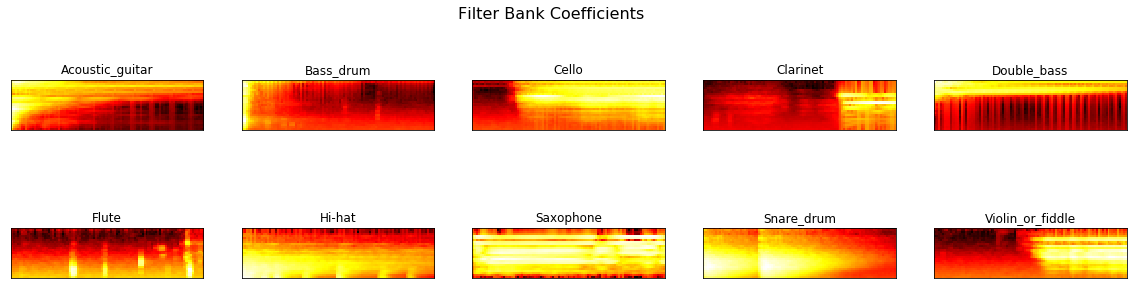

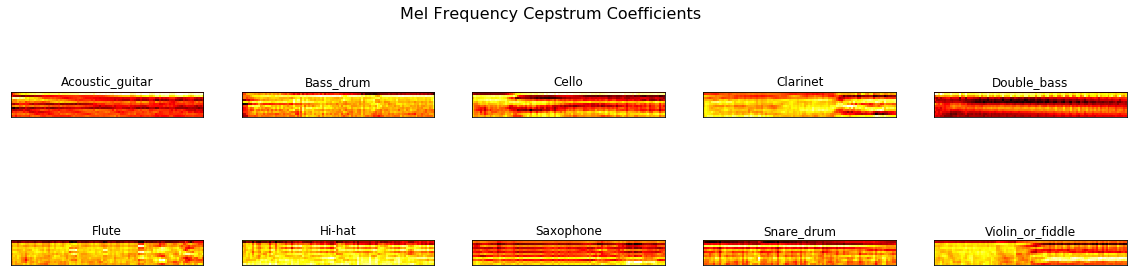

In [279]:
# Let us do all the plotting
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [9]:
# Now let us see one class only to see interclass variability

signals = {}
fft = {}
fbank = {}
mfccs = {}

c = classes[4]
print(c)

dfc = df[df.label==c]

for k, wav_file in zip(range(len(dfc.fname)), dfc.fname):
    signal, rate = librosa.load('audio/wavfiles/'+wav_file, sr=44100)
    signals[k] = signal
    fft[k] = calc_fft(signal, rate)
    
    # nfft = (44100samples/second) / (40 intervals/sec)
    # 40 intervals/sec = 25 milliseconds (resolution)
    # nfft = 1103 samples/interval (size of the window)
    bank = logfbank(signal[:rate],rate, nfilt=26,nfft=1103).T
    fbank[k] = bank
    
    ## note that nfilt was 26 so we throw away half
    mfc= mfcc(signal[:rate],rate, numcep = 13, nfilt=26, nfft=1103).T
    mfccs[k] = mfc

Double_bass


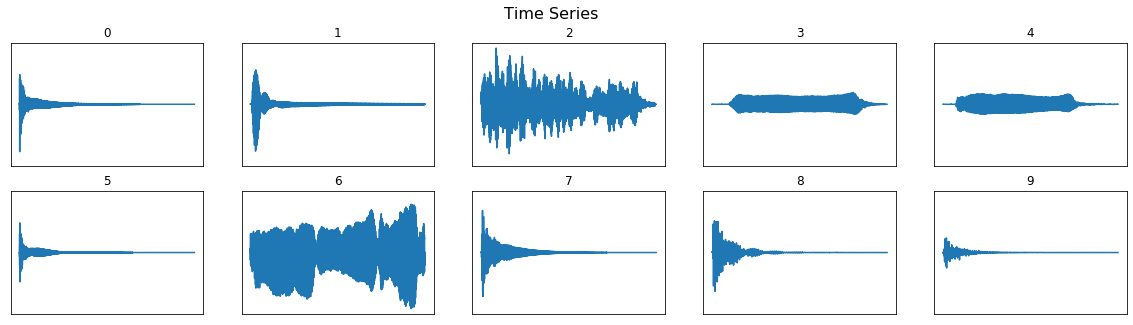

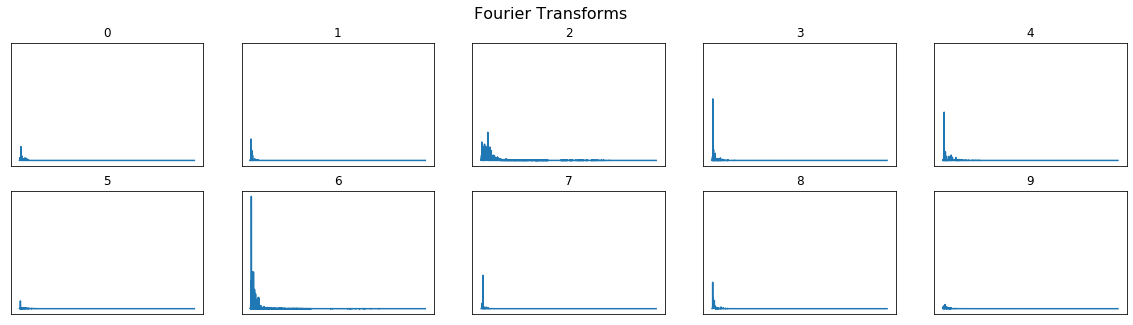

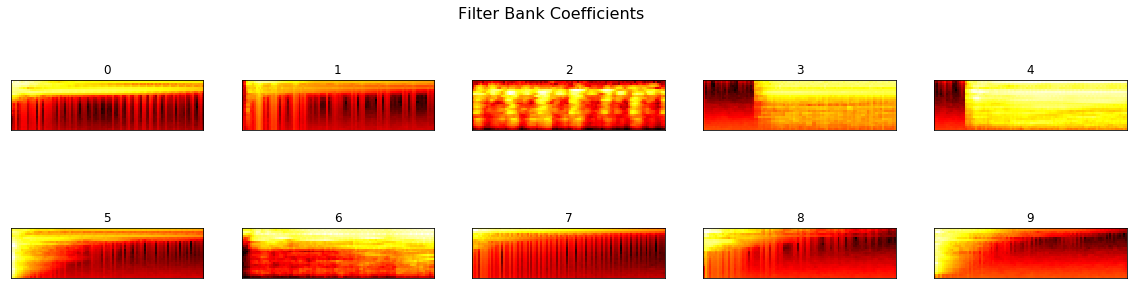

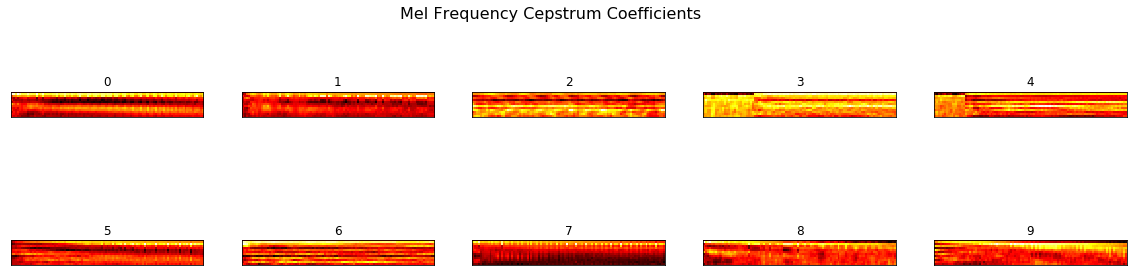

In [10]:
# Let us do all the plotting

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [308]:
# Building the Model 
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

df = pd.read_csv('audio/instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('audio/wavfiles/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

In [309]:
# determine how many samples we can have of a particular length.
# in this case we use 0.1 second as the duration

# summing all the lengths and dividing by 0.1 gives
# us the total number of 0.1 second segmentws

n_samples = 2 * int(df['length'].sum()/0.1)
print(n_samples)

30444


In [13]:
# Use the envelop to clean data
def envelop(y, rate, threshold):
    mask=[]
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean> threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [310]:
# Do stratified sampling 
classes = list(np.unique(df.label))
class_dist = df.groupby('label')['length'].mean()
prob_dist = class_dist/class_dist.sum()
print(prob_dist)
choices= np.random.choice(class_dist.index,p=prob_dist)
print(choices)

label
Acoustic_guitar     0.136941
Bass_drum           0.038180
Cello               0.098551
Clarinet            0.129991
Double_bass         0.063182
Flute               0.158738
Hi-hat              0.066165
Saxophone           0.140397
Snare_drum          0.078581
Violin_or_fiddle    0.089275
Name: length, dtype: float64
Cello


In [311]:
# make a class with all the configuration parameters
class Config:
    def __init__(self, nfilt=26, nfeat=13, nfft=1103, rate=44100):
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = (rate/10)
        # each step is 1/10th of a second 
        # will be 4410 values for 0.1 seconds

config = Config()
print(config.step)

4410.0


In [312]:
# summing all the lengths and dividing by 0.1 gives
# us the total number of 0.1 second segmentws
n_samples = 2 * int(df['length'].sum()/0.1)

# make fname the index again

# Building and normalizing data
def build_random_feat():
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        # randomly generate a label based on distribution
        rand_class= np.random.choice(class_dist.index,p=prob_dist)
        # randomly select one record of the class selected
        df_rand = df[df.label==rand_class]
        file = np.random.choice(df_rand.index)
        # read the wav file
        rate,wav = wavfile.read('audio/wavfiles/'+file)
        # find the corresponding label
        label = df.at[file,'label']
        # get a random sample of 0.1 seconds from the sample
        # subtract 0.1 second to make sure we always get
        # at least one second
        random_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[int(random_index):int(random_index+config.step)]
        # Now create the feature set and transpose it because we 
        # want time to be the x-axis and mfcc to be y
        X_sample = mfcc(sample, 
                        rate, 
                        numcep = config.nfeat,
                        nfilt = config.nfilt,
                        nfft = config.nfft)
        # Update min and max
        __min = np.amin(X_sample)
        __max = np.amax(X_sample)
        
        if(__min<_min):
            _min = __min
        if(__max>_max):
            _max = __max
        
        # add X and y to correponding lists
        X.append(X_sample)
        # add the integer label correponding to the class
        y.append(classes.index(label))
        
    # convert into numpy arrays
    
    X, y = np.array(X), np.array(y)
    
    # normalize X
    X = (X - _min)/ (_max-_min)
    
    # Reshape for the NN
    
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = to_categorical(y,num_classes=10)
    
    return X, y

# actually build it

X, y = build_random_feat()



 16%|█▌        | 4929/30444 [00:14<01:07, 379.67it/s]


 36%|███▌      | 10857/30444 [00:29<00:47, 408.96it/s]


 54%|█████▎    | 16294/30444 [00:43<00:36, 387.57it/s]


 71%|███████   | 21666/30444 [00:58<00:24, 351.95it/s]


 89%|████████▉ | 27191/30444 [01:13<00:09, 348.56it/s]


100%|██████████| 30444/30444 [01:21<00:00, 372.04it/s]


In [315]:
# Let us see the shapes
print(X.shape)
print(y.shape)

# the original 1D tensor for y
y_flat = np.argmax(y, axis=1)

# what does one X point look like. 
print(X[0])

(30444, 9, 13, 1)
(30444, 10)
[[0.56441395]
 [0.37017309]
 [0.56488491]
 [0.51901034]
 [0.55018825]
 [0.58587311]
 [0.65459366]
 [0.66996736]
 [0.60028852]
 [0.51802195]
 [0.49464047]
 [0.5222317 ]
 [0.5857623 ]]


In [316]:
#define the convolution network -- even though the 
#input is a 4D tensor 
input_shape = (X.shape[1], X.shape[2], 1)

# convolutional model 
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',
                 strides=(1,1), padding='same',
                 input_shape=input_shape))
model.add(Conv2D(32,(3,3),activation='relu',
                 strides=(1,1), padding='same'))
model.add(Conv2D(64,(3,3),activation='relu',
                 strides=(1,1), padding='same'))
model.add(Conv2D(128,(3,3),activation='relu',
                 strides=(1,1), padding='same'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(10,  activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 6, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3072)             

In [317]:
# Compile the model 
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics =['acc'])

In [318]:
# handling imbalanced data 
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)
model.fit(X,y,epochs=1, batch_size=32, class_weight=class_weight)

Epoch 1/1
30444/30444 [==============================] - 40s 1ms/step - loss: 1.0616 - acc: 0.6209


In [326]:
# Example #2. --  Doing urban sound classification
# Adapted from various samples on the Internet
import os
import librosa
import librosa.display
import glob 
import skimage

# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [327]:
# make sure that urnabsound8k is in the same directory
# as the Audio CNN notebook
df = pd.read_csv("urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [328]:
# load two random sample files 
# each will return the actual data and the 
# sampling rate. Note we are using librosa here

dat1, sampling_rate1 = librosa.load('urbansound8k/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('urbansound8k/fold5/100263-2-0-117.wav')

print(sampling_rate1)
print(sampling_rate2) ##22050 khz 

22050
22050


Text(0.5, 1.0, 'Linear-frequency power spectrogram')

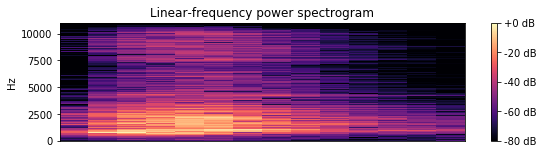

In [320]:
#Plot the Linear-frequency power spectrium 
#Using Librosa for the liner power spectrum
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# note that it is time vs. frequency on the y-axis.

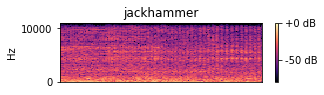

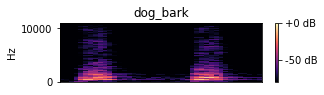

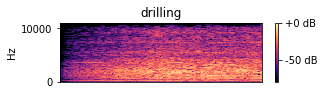

In [329]:
#'''Using random samples to observe difference in waveforms.'''
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

#  we can change the range here to see differences. 
for i in range(192, 197, 2):
    path = 'urbansound8k/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [330]:
# lets load the features
# note that we are using default parameters for all the parameters
dat1, sampling_rate1 = librosa.load('urbansound8k/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

In [331]:
# Now we need to load the data
# df has the table we are using to read the data

feature = []
label = []

NUM_DATA = 100

def parser(row):
    # Function to load files and extract features
    # 8732 actual number of images
    # we will do 100
    for i in range(NUM_DATA):
        file_name = 'urbansound8k/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # print("file name=",file_name)
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        # Here kaiser_fast is a technique used for faster extraction
        # X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        # mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        # feature.append(mels)
        feature.append(mfccsscaled)
        label.append(df["classID"][i])
    return [feature, label]

In [332]:
# df 
print(df.head)
# load all the data
temp = parser(df)
# labels
print(temp[1])

<bound method NDFrame.head of          slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          

In [333]:
# convert from pd to np array
# transpose so each feature/class 
# is in a single row. 
temp = np.array(temp)
data = temp.transpose()
print(data.shape)

(100, 2)


In [335]:
X_ = data[:, 0]
Y_ = data[:, 1]
print(X_.shape, Y_.shape)
X = np.empty([NUM_DATA, 128])  # nmcff was 40
Y = np.empty([NUM_DATA,1])

(100,) (100,)


In [336]:
for i in range(NUM_DATA):
    X[i] = (X_[i])
for i in range(NUM_DATA):
    Y[i] = (Y_[i])
    
print(X.shape)
print(Y.shape)

(100, 128)
(100, 1)


In [337]:
Y = to_categorical(Y)
print(Y.shape)
print(Y[0])

(100, 10)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [338]:
'''Final Data'''
print(X.shape)
print(Y.shape)

(100, 128)
(100, 10)


In [339]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

print(X_train.shape)
print(Y_train.shape)

(75, 128)
(75, 10)


In [340]:
# mffcc was 128 = 16 x 8 (we split it up)
num_rows = 8
num_columns = 16
num_channels = 1

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

In [341]:
input_dim = (num_rows, num_columns, num_channels)

model = Sequential()
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 16, 64)         640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 4, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1

In [342]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [343]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 50, validation_data = (X_test, Y_test))

Train on 75 samples, validate on 25 samples
Epoch 1/2
75/75 [==============================] - 1s 17ms/sample - loss: 2.1832 - accuracy: 0.4667 - val_loss: 0.7581 - val_accuracy: 0.7600
Epoch 2/2
75/75 [==============================] - 0s 2ms/sample - loss: 1.1247 - accuracy: 0.5333 - val_loss: 0.4933 - val_accuracy: 0.8800


In [344]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

25/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 271us/sample - loss: 0.4933 - accuracy: 0.8800
[0.49326789379119873, 0.88]
